<a href="https://colab.research.google.com/github/hawkmak3r/NLP/blob/master/NLP_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing pandas library for reading our csv file
import pandas as pd
#from sklearn we import a train_test_split which helps us to divide our data of
#housing into 2 sets train and test model
from sklearn.model_selection import train_test_split
#importing numpy helps us to work with data and modify as per our need
import numpy as np
#for ploting our graphs
import matplotlib.pyplot as plt

#imports require for our network
import torch
#under are different layers we need
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import  Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset



In [105]:
#importing dataset and remove any N/A entries 
#pls change path as per your data stored 
data_set = pd.read_csv('/content/housing.csv')
data_set = data_set.dropna()

#perfroming visualization
#as given in assignmet first we printed 10 records then we printed our plots 
#wwhich ar given in the assignment
#first ten records from out dataset
data_set.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f23b5ec6978>,
      dtype=object)

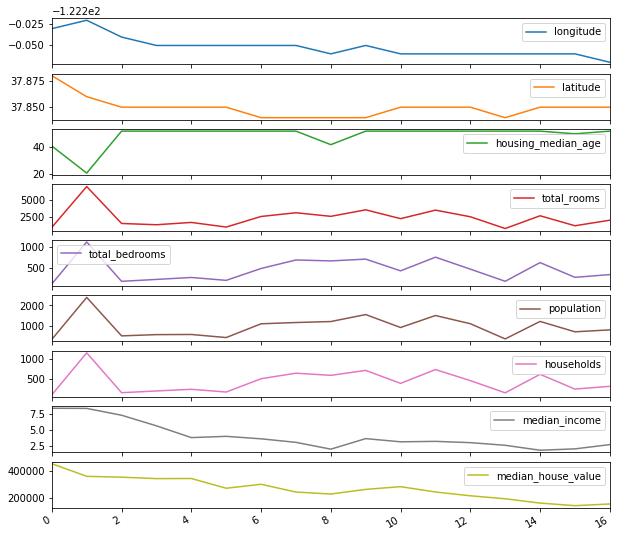

In [106]:
#plots 
#plots 
DS=data_set[:17]
plots=pd.DataFrame(DS,columns= DS.columns)
plots.plot(subplots=True, figsize=(10, 10) )

In [0]:
#for predicting medain house value column we define it as our Y variable
Y = data_set['median_house_value']
#for predicting we will use  longitude, latitude, housing median age, total 
#number of rooms, total number of bedrooms, population, number of households, 
#and median income. Defining those as X
X = data_set.loc[:,'longitude':'median_income']



In [108]:
#spliting our data 70% for training and 30% for testing while random state is
#set to 2003
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=2003)

#to manipulate data we will convert it into numpy arrays 
#training data
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
#test data
x_test_np = x_test.to_numpy() 
y_test_np = y_test.to_numpy()



<function print>

In [0]:
#definning our network for predication 

class Nlp_assignment1(torch.nn.Module):
  def __init__(self, b_size, inputs, outputs):

    super(Nlp_assignment1, self).__init__()
    self.b_size = b_size
    self.inputs = inputs
    self.outputs = outputs 

    #first layer our input layer
    self.input_layer = Conv1d(inputs, b_size, 1)
    
    #creating a max pooling layer
    self.mpool_layer = MaxPool1d(1)

    # Define another convolution layer
    self.conv_layer = Conv1d(b_size , 128 , 1)

    self.flatten_layer = Flatten()

    self.lr_layer = Linear(128 , 64)
    
    #final a output layer
    self.out_layer = Linear(64, outputs)

    #All the layer are set
    #creating feeding method to give our inputs to our layer 

  def feeder(self, input):
    #as we using 1D convolution while our data is 3d we need to feed that data
    #1d way
    input = input.reshape((self.b_size, self.inputs, 1))

    output = relu(self.input_layer(input))

    output = self.mpool_layer(output)

    output = relu(self.conv_layer(output))

    output = self.flatten_layer(output)

    output = self.lr_layer(output)

    output = self.out_layer(output)

    return output

In [110]:
#block of training our model

from torch.optim import SGD
from torch.optim import Adam
from torch.nn import L1Loss
from torchvision import models

!pip install pytorch-ignite

from ignite.contrib.metrics.regression.r2_score import R2Score


b_size = 32

model = Nlp_assignment1(b_size, X.shape[1], 1)
print('as we can see from method our kernal size is 3 x 3 ')
print('The total number of trainable paramaeters are ',sum([param.nelement() for param in model.parameters()]))
model.cuda()



as we can see from method our kernal size is 3 x 3 
The total number of trainable paramaeters are  12833


Nlp_assignment1(
  (input_layer): Conv1d(8, 32, kernel_size=(1,), stride=(1,))
  (mpool_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(32, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (lr_layer): Linear(in_features=128, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
#Function for Average L1 loss and our R2 score 
def cal_loss(model, data_set, train = False, optimizer = None):
  perf = L1Loss()
  score_r = R2Score()

  avg_loss, avg_score, count = 0, 0, 0
  for input, output in iter(data_set):

    predict = model.feeder(input)

    l = perf(predict, output)

    score_r.update([predict, output])
    score = score_r.compute()

    if(train):

      optimizer.zero_grad()

      l.backward()

      optimizer.step()

    avg_loss += l.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count

In [112]:
epochs = 100

# here we are using Adam becuase SGD fails to compute as per our requirement and
#Adam provides us better output then SGD
optimizer = Adam(model.parameters() , lr=1e-3)

#Again as done before we are converting data in numpy arrary so we can manipulate
#it as per our wish
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
#creating a Dataloader for loading our given data for batchs 
tensor = TensorDataset(inputs , outputs)
loader = DataLoader(tensor, b_size, shuffle = True, drop_last = True)
#Starting our timer for training model
from time import perf_counter
t1_start = perf_counter()  
#intitaling our loop with given number of epochs 
for epoch in range(epochs): 
# going through the batches and get the average loss 
  avg_loss, avg_r2_score = cal_loss(model, loader, train=True, optimizer=optimizer)
# printing average loss per one epoch as we train though them
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1 )).cuda().float()

tensor = TensorDataset(inputs, outputs) 
loader = DataLoader(tensor, b_size, shuffle=True, drop_last=True)

avg_loss, avg_r2_score = cal_loss(model, loader) 
print("this model has L1 loss: " + str(avg_loss)) 
print("This model has a  R^2 score of " + str(avg_r2_score))
t1_stop = perf_counter() 
  
print("Inference time in seconds ", t1_stop-t1_start)


Epoch 1:
	Loss = 143792.4634325916
	R^2 Score = -2.3936428931944143
Epoch 2:
	Loss = 110377.23907886125
	R^2 Score = -0.8752878480896257
Epoch 3:
	Loss = 92340.72239037958
	R^2 Score = -0.3738484941253515
Epoch 4:
	Loss = 83321.77149460079
	R^2 Score = 0.11494034862984337
Epoch 5:
	Loss = 81576.20388170812
	R^2 Score = 0.1641831937687699
Epoch 6:
	Loss = 80908.89649460079
	R^2 Score = 0.18087575985715032
Epoch 7:
	Loss = 79786.1284154123
	R^2 Score = 0.20043930472412194
Epoch 8:
	Loss = 78954.14800801701
	R^2 Score = 0.19979802883054443
Epoch 9:
	Loss = 77986.05076079843
	R^2 Score = 0.2334358369510932
Epoch 10:
	Loss = 78137.35088759816
	R^2 Score = 0.25216759134416145
Epoch 11:
	Loss = 76363.11319944372
	R^2 Score = 0.2784824845457831
Epoch 12:
	Loss = 75475.24447807591
	R^2 Score = 0.29696378261643713
Epoch 13:
	Loss = 74430.05941181282
	R^2 Score = 0.2984286082251951
Epoch 14:
	Loss = 73054.11389479712
	R^2 Score = 0.3310263118659359
Epoch 15:
	Loss = 72423.00476521597
	R^2 Score =

In [0]:
import pickle

with open('0889960_1dconv_reg' ,'wb' ) as f:
  pickle.dump(model,f)
